# **ICESat-2 Active Subglacial Lakes in Antarctica**

Finding subglacial lakes that are draining or filling under the ice!
They can be detected with ICESat-2 data, as significant changes in height
(> 1 metre) over a relatively short duration (< 1 year), i.e. a high rate of
elevation change over time (dhdt).

In this notebook, we'll use some neat tools to help us examine the lakes:
- To find active subglacial lake boundaries,
use an *unsupervised clustering* technique
- To see ice surface elevation trends at a higher temporal resolution (< 3 months),
perform *crossover track error analysis* on intersecting ICESat-2 tracks

To speed up analysis on millions of points,
we will use state of the art GPU algorithms enabled by RAPIDS AI libraries,
or parallelize the processing across our HPC's many CPU cores using Dask.

In [1]:
import itertools
import os
import subprocess

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cudf
import cuml
import dask
import dask.array
import geopandas as gpd
import hvplot.xarray
import numpy as np
import pandas as pd
import panel as pn
import pygmt
import scipy.spatial
import shapely.geometry
import tqdm
import xarray as xr
import zarr

import deepicedrain

In [ ]:
tag: str = "X2SYS"
os.environ["X2SYS_HOME"] = os.path.abspath(tag)
client = dask.distributed.Client(
    n_workers=64, threads_per_worker=1, env={"X2SYS_HOME": os.environ["X2SYS_HOME"]}
)
client

# Data Preparation

In [3]:
min_date, max_date = ("2018-10-14", "2020-09-30")

In [4]:
if not os.path.exists("ATLXI/df_dhdt_antarctica.parquet"):
    zarrarray = zarr.open_consolidated(store=f"ATLXI/ds_dhdt_antarctica.zarr", mode="r")
    _ = deepicedrain.ndarray_to_parquet(
        ndarray=zarrarray,
        parquetpath="ATLXI/df_dhdt_antarctica.parquet",
        variables=["x", "y", "dhdt_slope", "referencegroundtrack"],  # "h_corr"],
        dropnacols=["dhdt_slope"],
    )

In [5]:
# Read in Antarctic Drainage Basin Boundaries shapefile into a GeoDataFrame
ice_boundaries: gpd.GeoDataFrame = (
    deepicedrain.catalog.measures_antarctic_boundaries.read()
)
drainage_basins: gpd.GeoDataFrame = ice_boundaries.query(expr="TYPE == 'GR'")

## Load in ICESat-2 data (x, y, dhdt) and do initial trimming

In [6]:
# Read in raw x, y, dhdt_slope and referencegroundtrack data into the GPU
cudf_raw: cudf.DataFrame = cudf.read_parquet(
    filepath_or_buffer="ATLXI/df_dhdt_antarctica.parquet",
    columns=["x", "y", "dhdt_slope", "referencegroundtrack"],
)
# Filter to points with dhdt that is less than -0.2 m/yr or more than +0.2 m/yr
cudf_many = cudf_raw.loc[abs(cudf_raw.dhdt_slope) > 0.2]
print(f"Trimmed {len(cudf_raw)} -> {len(cudf_many)}")

Trimmed 221789253 -> 51953674


In [7]:
# Clip outlier values to 3 sigma (standard deviations) from mean
_mean = cudf_many.dhdt_slope.mean()
_std = cudf_many.dhdt_slope.std()
cudf_many.dhdt_slope.clip(
    lower=np.float32(_mean - 3 * _std), upper=np.float32(_mean + 3 * _std), inplace=True
)

## Label ICESat-2 points according to their drainage basin

Uses Point in Polygon.
For each point, find out which Antarctic Drainage Basin they are in.
This will also remove the points on floating (FR) ice shelves and islands (IS),
so that we keep only points on the grounded (GR) ice regions.

In [8]:
# Use point in polygon to label points according to the drainage basins they fall in
cudf_many["drainage_basin"]: cudf.Series = deepicedrain.point_in_polygon_gpu(
    points_df=cudf_many, poly_df=drainage_basins
)
X_many = cudf_many.dropna()  # drop points that are not in a drainage basin
print(f"Trimmed {len(cudf_many)} -> {len(X_many)}")

Trimmed 51953674 -> 24799529


# Find Active Subglacial Lake clusters

Uses Density-based spatial clustering of applications with noise (DBSCAN).

### Subglacial Lake Finder algorithm

For each Antarctic drainage basin:

1. Select all points with significant elevation change over time (dhdt)
  - Specifically, the (absolute) dhdt value should be
    2x the median (absolute) dhdt for that drainage basin
  - E.g. if median dhdt for basin is 0.35 m/yr,
    we choose points that have dhdt > 0.70 m/yr
2. Run unsupervised clustering to pick out active subglacial lakes
  - Split into draining (-dhdt) and filling (+dhdt) points first
  - Use DBSCAN algorithm to cluster points into groups,
    with an eps (distance) of 3 km and minimum sample size of 250 points
3. Check each potential point cluster to see if it meets active lake criteria
  1. Build a convex hull 'lake' polygon around clustered points
  2. Check that the 'lake' has significant elevation change relative to outside
    - For the area in the 5 km buffer region **outside** the 'lake' polygon:
       - Find median dhdt (outer_dhdt)
       - Find median absolute deviation of dhdt values (outer_mad)
    - For the area **inside** the 'lake' polygon:
       - Find median dhdt (inner_dhdt)
    - If the potential lake shows an elevation change that is more than
      3x the surrounding deviation of background elevation change,
      we infer that this is likely an active subglacial 'lake'

In [9]:
# Subglacial lake finder
activelakes: dict = {
    "basin_name": [],  # Antarctic drainage basin name
    "num_points": [],  # Number of clustered data points
    "outer_dhdt": [],  # Median elevation change over time (dhdt) outside of lake
    "outer_std": [],  # Standard deviation of dhdt outside of lake
    "outer_mad": [],  # Median absolute deviation of dhdt outside of lake
    "inner_dhdt": [],  # Median elev change over time (dhdt) inside of lake bounds
    "maxabsdhdt": [],  # Maximum absolute dhdt value inside of lake boundary
    "refgtracks": [],  # Pipe-delimited list of ICESat-2 reference ground tracks
    "geometry": [],  # Shapely Polygon geometry holding lake boundary coordinates
}
basin_name: str = "Whillans"  # Set a basin name here
basins = drainage_basins[drainage_basins.NAME == basin_name].index  # one specific basin
basins: pd.core.indexes.numeric.Int64Index = drainage_basins.index  # run on all basins
for basin_index in tqdm.tqdm(iterable=basins):
    # Initial data cleaning, filter to rows that are in the drainage basin
    basin = drainage_basins.loc[basin_index]
    X_local = X_many.loc[X_many.drainage_basin == basin.NAME]  # .reset_index(drop=True)

    # Get points with dhdt_slope higher than 2x the median dhdt_slope for the basin
    # E.g. if median dhdt_slope is 0.35 m/yr, then we cluster points over 0.70 m/yr
    abs_dhdt = X_local.dhdt_slope.abs()
    tolerance: float = 2 * abs_dhdt.median()
    X = X_local.loc[abs_dhdt > tolerance]

    if len(X) <= 1000:  # don't run on too few points
        continue

    # Run unsupervised clustering separately on draining and filling lakes
    # Draining lake points have negative labels (e.g. -1, -2, 3),
    # Filling lake points have positive labels (e.g. 1, 2, 3),
    # Noise points have NaN labels (i.e. NaN)
    cluster_vars = ["x", "y", "dhdt_slope"]
    draining_lake_labels = -deepicedrain.find_clusters(
        X=X.loc[X.dhdt_slope < 0][cluster_vars]
    )
    filling_lake_labels = deepicedrain.find_clusters(
        X=X.loc[X.dhdt_slope > 0][cluster_vars]
    )
    lake_labels = cudf.concat(objs=[draining_lake_labels, filling_lake_labels])
    lake_labels: cudf.Series = lake_labels.sort_index()
    assert lake_labels.name == "cluster_id"

    # Checking all potential subglacial lakes in a basin
    clusters: cudf.Series = lake_labels.unique()
    for cluster_label in clusters.to_array():
        # Store attribute and geometry information of each active lake
        lake_points: cudf.DataFrame = X.loc[lake_labels == cluster_label]

        # More data cleaning, dropping clusters with too few points
        try:
            assert len(lake_points) > 100
        except AssertionError:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        multipoint: shapely.geometry.MultiPoint = shapely.geometry.MultiPoint(
            points=lake_points[["x", "y"]].as_matrix()
        )
        convexhull: shapely.geometry.Polygon = multipoint.convex_hull

        # Filter out (most) false positive subglacial lakes
        # Check that elevation change over time in lake is anomalous to outside
        # The 5000 m distance from lake boundary setting is empirically based on
        # Smith et al. 2009's methodology at https://doi.org/10.3189/002214309789470879
        outer_ring_buffer = convexhull.buffer(distance=5000) - convexhull
        X_local["in_donut_ring"] = deepicedrain.point_in_polygon_gpu(
            points_df=X_local,
            poly_df=gpd.GeoDataFrame({"name": True, "geometry": [outer_ring_buffer]}),
        )
        outer_points = X_local.dropna(subset="in_donut_ring")
        outer_dhdt: float = outer_points.dhdt_slope.median()

        outer_std: float = outer_points.dhdt_slope.std()
        outer_mad: float = scipy.stats.median_abs_deviation(
            x=outer_points.dhdt_slope.to_pandas()
        )

        inner_dhdt: float = lake_points.dhdt_slope.median()
        X_local = X_local.drop(labels="in_donut_ring", axis="columns")

        # If lake interior's median dhdt value is within 3 median absolute deviations
        # of the lake exterior's dhdt value, we remove the lake label
        # I.e. skip if above background change not significant enough
        # Inspired by Kim et al. 2016's methodology at https://doi.org/10.5194/tc-10-2971-2016
        if abs(inner_dhdt - outer_dhdt) < 3 * outer_mad:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        maxabsdhdt: float = (
            lake_points.dhdt_slope.max()
            if cluster_label > 0  # positive label = filling
            else lake_points.dhdt_slope.min()  # negative label = draining
        )
        refgtracks: str = "|".join(
            map(str, lake_points.referencegroundtrack.unique().to_pandas())
        )

        # Save key variables to dictionary that will later go into geodataframe
        activelakes["basin_name"].append(basin.NAME)
        activelakes["num_points"].append(len(lake_points))
        activelakes["outer_dhdt"].append(outer_dhdt)
        activelakes["outer_std"].append(outer_std)
        activelakes["outer_mad"].append(outer_mad)
        activelakes["inner_dhdt"].append(inner_dhdt)
        activelakes["maxabsdhdt"].append(maxabsdhdt)
        activelakes["refgtracks"].append(refgtracks)
        activelakes["geometry"].append(convexhull)

    # Calculate total number of lakes found for one drainage basin
    clusters: cudf.Series = lake_labels.unique()
    n_draining, n_filling = (clusters < 0).sum(), (clusters > 0).sum()
    if n_draining + n_filling > 0:
        print(f"{len(X)} rows at {basin.NAME} above ± {tolerance:.2f} m/yr")
        print(f"{n_draining} draining and {n_filling} filling lakes found")

if len(activelakes["geometry"]) >= 1:
    gdf = gpd.GeoDataFrame(activelakes, crs="EPSG:3031")
    basename = "antarctic_subglacial_lakes"  # f"temp_{basin_name.lower()}_lakes"  #
    gdf.to_file(filename=f"{basename}_3031.geojson", driver="GeoJSON")
    gdf.to_crs(crs={"init": "epsg:4326"}).to_file(
        filename=f"{basename}_4326.geojson", driver="GeoJSON"
    )

print(f"Total of {len(gdf)} subglacial lakes found")

  1%|          | 2/198 [00:00<01:11,  2.72it/s]

51392 rows at Academy above ± 0.56 m/yr
1 draining and 7 filling lakes found


 10%|█         | 20/198 [00:02<00:16, 10.65it/s]

12954 rows at Borchgrevink above ± 0.57 m/yr
1 draining and 0 filling lakes found


 21%|██        | 41/198 [00:05<01:03,  2.49it/s]

59169 rows at Totten above ± 0.71 m/yr
1 draining and 0 filling lakes found
41799 rows at Moscow above ± 0.64 m/yr
0 draining and 1 filling lakes found


 28%|██▊       | 56/198 [00:06<00:15,  9.30it/s]

29974 rows at Cook above ± 0.59 m/yr
0 draining and 1 filling lakes found
20650 rows at David above ± 0.62 m/yr
1 draining and 1 filling lakes found


 29%|██▉       | 58/198 [00:07<00:34,  4.01it/s]

71140 rows at Mercer above ± 0.63 m/yr
2 draining and 6 filling lakes found


 32%|███▏      | 63/198 [00:20<04:27,  1.98s/it]

353413 rows at Pine_Island above ± 0.80 m/yr
2 draining and 0 filling lakes found


 33%|███▎      | 65/198 [00:23<03:47,  1.71s/it]

207182 rows at Thwaites above ± 0.70 m/yr
3 draining and 5 filling lakes found


 36%|███▌      | 71/198 [00:26<02:07,  1.00s/it]

128817 rows at Whillans above ± 0.64 m/yr
5 draining and 19 filling lakes found


 37%|███▋      | 73/198 [00:27<01:27,  1.43it/s]

33915 rows at Kamb above ± 0.61 m/yr
2 draining and 7 filling lakes found
8195 rows at Leverett above ± 0.71 m/yr
1 draining and 0 filling lakes found


 37%|███▋      | 74/198 [00:28<01:38,  1.26it/s]

66486 rows at Scott above ± 0.63 m/yr
1 draining and 3 filling lakes found


 39%|███▉      | 78/198 [00:29<00:59,  2.02it/s]

38507 rows at Amundsen above ± 0.70 m/yr
1 draining and 0 filling lakes found


 40%|███▉      | 79/198 [00:29<00:47,  2.51it/s]

49665 rows at Beardmore above ± 0.70 m/yr
0 draining and 1 filling lakes found


 41%|████▏     | 82/198 [00:29<00:37,  3.11it/s]

38054 rows at Nimrod above ± 0.67 m/yr
1 draining and 0 filling lakes found


 44%|████▍     | 87/198 [00:30<00:27,  4.05it/s]

63514 rows at Byrd above ± 0.64 m/yr
5 draining and 3 filling lakes found


 45%|████▌     | 90/198 [00:31<00:27,  3.98it/s]

35282 rows at MacAyeal above ± 0.59 m/yr
4 draining and 1 filling lakes found


 46%|████▋     | 92/198 [00:31<00:24,  4.35it/s]

39916 rows at Rutford above ± 0.75 m/yr
1 draining and 2 filling lakes found


 49%|████▉     | 97/198 [00:32<00:17,  5.89it/s]

60504 rows at Evans above ± 0.62 m/yr
1 draining and 0 filling lakes found


 56%|█████▌    | 110/198 [00:32<00:06, 12.70it/s]

37068 rows at Slessor above ± 0.59 m/yr
10 draining and 4 filling lakes found
19684 rows at Support_Force above ± 0.55 m/yr
3 draining and 0 filling lakes found


 59%|█████▊    | 116/198 [00:34<00:15,  5.14it/s]

55961 rows at Foundation above ± 0.52 m/yr
1 draining and 8 filling lakes found
13969 rows at Lambert above ± 0.52 m/yr
0 draining and 1 filling lakes found
14412 rows at Mellor above ± 0.53 m/yr
1 draining and 1 filling lakes found


 62%|██████▏   | 122/198 [00:35<00:10,  6.93it/s]

7281 rows at Fisher above ± 0.56 m/yr
0 draining and 1 filling lakes found


 68%|██████▊   | 134/198 [00:36<00:07,  8.67it/s]

31328 rows at Institute above ± 0.53 m/yr
5 draining and 2 filling lakes found
7266 rows at Fleming above ± 1.45 m/yr
1 draining and 0 filling lakes found


 69%|██████▊   | 136/198 [00:36<00:08,  7.33it/s]

17100 rows at Haynes above ± 0.98 m/yr
1 draining and 0 filling lakes found


 71%|███████   | 140/198 [00:37<00:11,  4.99it/s]

26112 rows at Ross_East2 above ± 0.84 m/yr
1 draining and 0 filling lakes found
31433 rows at Bowman_Strom_Live_Axel-Heigerg above ± 0.85 m/yr
1 draining and 0 filling lakes found


 72%|███████▏  | 143/198 [00:38<00:11,  4.87it/s]

38716 rows at Sulzberger above ± 0.82 m/yr
2 draining and 0 filling lakes found


 73%|███████▎  | 145/198 [00:38<00:08,  5.89it/s]

6313 rows at Lucchitta_Velasco above ± 0.94 m/yr
1 draining and 0 filling lakes found


 74%|███████▎  | 146/198 [00:40<00:27,  1.89it/s]

121993 rows at Getz above ± 1.27 m/yr
4 draining and 0 filling lakes found


 75%|███████▌  | 149/198 [00:40<00:16,  3.03it/s]

32067 rows at Abbot above ± 1.85 m/yr
0 draining and 2 filling lakes found


 82%|████████▏ | 163/198 [00:42<00:06,  5.65it/s]

40632 rows at Recovery above ± 0.55 m/yr
3 draining and 5 filling lakes found


 99%|█████████▉| 196/198 [00:43<00:00, 14.67it/s]

26316 rows at Hull above ± 0.92 m/yr
1 draining and 0 filling lakes found


100%|██████████| 198/198 [00:43<00:00,  4.53it/s]

Total of 149 subglacial lakes found


## Visualize lakes

In [10]:
# Concatenate XY points with labels, and move data from GPU to CPU
X: cudf.DataFrame = cudf.concat(objs=[X, lake_labels], axis="columns")
X_ = X.to_pandas()

In [ ]:
# Plot clusters on a map in colour, noise points/outliers as small dots
fig = pygmt.Figure()
n_clusters_ = len(X_.cluster_id.unique()) - 1  # No. of clusters minus noise (NaN)
sizes = (X_.cluster_id.isna()).map(arg={True: 0.01, False: 0.1})
pygmt.makecpt(cmap="polar", series=(-1, 3, 2), color_model="+cDrain,Fill", reverse=True)
fig.plot(
    x=X_.x,
    y=X_.y,
    sizes=sizes,
    style="cc",
    color=pd.cut(x=X_.cluster_id, bins=(-np.inf, 0, np.inf), labels=[-1, 1]),
    cmap=True,
    frame=[
        f'WSne+t"Estimated number of lake clusters at {basin.NAME}: {n_clusters_}"',
        'xafg+l"Polar Stereographic X (m)"',
        'yafg+l"Polar Stereographic Y (m)"',
    ],
)
basinx, basiny = basin.geometry.exterior.coords.xy
fig.plot(x=basinx, y=basiny, pen="thinnest,-")
fig.colorbar(position='JMR+w2c/0.5c+e+m+n"Unclassified"', L="i0.5c")
fig.savefig(fname=f"figures/subglacial_lake_clusters_at_{basin.NAME}.png")
fig.show()

# Select a subglacial lake to examine

In [13]:
# Save or load dhdt data from Parquet file
placename: str = "siple_coast"  # "slessor_downstream"  #  "Recovery"  # "Whillans"
try:
    drainage_basins: gpd.GeoDataFrame = drainage_basins.set_index(keys="NAME")
    region: deepicedrain.Region = deepicedrain.Region.from_gdf(
        gdf=drainage_basins.loc[placename], name="Recovery Basin"
    )
except KeyError:
    pass
df_dhdt: cudf.DataFrame = cudf.read_parquet(
    f"ATLXI/df_dhdt_{placename.lower()}.parquet"
)

In [14]:
# Antarctic subglacial lake polygons with EPSG:3031 coordinates
antarctic_lakes: gpd.GeoDataFrame = deepicedrain.catalog.subglacial_lakes.read()
antarctic_lakes = antarctic_lakes.set_crs(epsg=3031, allow_override=True)

basin_name                                             Whillans
num_points                                                 3276
outer_dhdt                                             0.377611
outer_std                                               1.42712
outer_mad                                              0.083278
inner_dhdt                                              2.12607
maxabsdhdt                                              8.65662
refgtracks    74|135|196|266|327|388|516|577|638|769|830|101...
geometry      POLYGON ((-444681.0351994165 -545210.454471163...
Name: 50, dtype: object


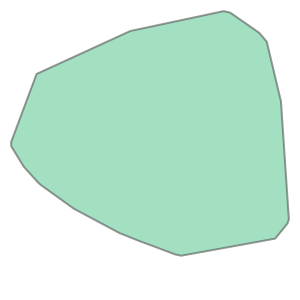

In [15]:
# Choose one draining/filling lake
draining: bool = False
placename: str = "Whillans"  # "Slessor"  # "Kamb"  # "Mercer"  #
lakes: gpd.GeoDataFrame = antarctic_lakes  # .query(expr="basin_name == @placename")

lake_ids: int = (44,)  # single lake
lake_ids: tuple = (41, 43, 45)  # lake mega-cluster
# TODO handle Lake 78 cross-basin by using dissolve(by=None) available
# in geopandas v0.9.0 https://github.com/geopandas/geopandas/pull/1568
lake = lakes.loc[list(lake_ids)].dissolve(by="basin_name", as_index=False).squeeze()
lakedict = {
    (15, 19): "Subglacial Lake Mercer",  # filling lake
    (32,): "Whillans 7",  # draining lake
    (34, 35): "Subglacial Lake Conway",  # draining lake
    (41, 43, 45): "Subglacial Lake Whillans",  # filling lake
    (16, 46, 48): "Lake 78",  # filling lake
    (44,): "Whillans IX",  # filling lake
    (62,): "Kamb 1",  # filling lake
    # (65): "Kamb 12",  # filling lake
    (84,): "MacAyeal 1",  # draining lake
    (95,): "Slessor 45",  # draining lake
    (101,): "Slessor 23",  # filling lake
    (141,): "Recovery IV",  # draining lake
    (143, 144): "Recovery 2",  # filling lake
}
region = deepicedrain.Region.from_gdf(gdf=lake, name=lakedict[lake_ids])
assert (lake.inner_dhdt < 0 and draining) or (lake.inner_dhdt > 0 and not draining)

print(lake)
lake.geometry

In [16]:
# Subset data to lake of interest
placename: str = region.name.lower().replace(" ", "_")
df_lake: cudf.DataFrame = region.subset(data=df_dhdt)

# Save lake outline to OGR GMT file format
outline_points: str = f"figures/{placename}/{placename}.gmt"
if not os.path.exists(path=outline_points):
    lakes.loc[list(lake_ids)].to_file(filename=outline_points, driver="OGR_GMT")

## Create an interpolated ice surface elevation grid for each ICESat-2 cycle

In [17]:
# Generate gridded time-series of ice elevation over lake
cycles: tuple = (3, 4, 5, 6, 7, 8, 9)
os.makedirs(name=f"figures/{placename}", exist_ok=True)
ds_lake: xr.Dataset = deepicedrain.spatiotemporal_cube(
    table=df_lake.to_pandas(),
    placename=placename,
    cycles=cycles,
    folder=f"figures/{placename}",
)
ds_lake.to_netcdf(path=f"figures/{placename}/xyht_{placename}.nc", mode="w")

100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


In [18]:
# Get 3D grid_region (xmin/xmax/ymin/ymax/zmin/zmax),
# and calculate normalized z-values as Elevation delta relative to Cycle 3
z_limits: tuple = (float(ds_lake.z.min()), float(ds_lake.z.max()))  # original z limits
grid_region: tuple = region.bounds() + z_limits

ds_lake_diff: xr.Dataset = ds_lake - ds_lake.sel(cycle_number=3).z
z_diff_limits: tuple = (float(ds_lake_diff.z.min()), float(ds_lake_diff.z.max()))
diff_grid_region: np.ndarray = np.append(arr=grid_region[:4], values=z_diff_limits)

print(f"Elevation limits are: {z_limits}")

Elevation limits are: (273.2418518066406, 310.9927062988281)


In [ ]:
# 3D plots of gridded ice surface elevation over time
for cycle in tqdm.tqdm(iterable=cycles):
    time_nsec: pd.Timestamp = df_lake[f"utc_time_{cycle}"].to_pandas().mean()
    time_sec: str = np.datetime_as_string(arr=time_nsec.to_datetime64(), unit="s")

    # grid = ds_lake.sel(cycle_number=cycle).z
    fig = deepicedrain.plot_icesurface(
        grid=f"figures/{placename}/h_corr_{placename}_cycle_{cycle}.nc",
        grid_region=grid_region,
        diff_grid=ds_lake_diff.sel(cycle_number=cycle).z,
        diff_grid_region=diff_grid_region,
        track_points=df_lake[["x", "y", f"h_corr_{cycle}"]].dropna().as_matrix(),
        outline_points=outline_points,
        azimuth=157.5,  # 202.5  # 270
        elevation=45,  # 60
        title=f"{region.name} at Cycle {cycle} ({time_sec})",
    )
    fig.savefig(f"figures/{placename}/dsm_{placename}_cycle_{cycle}.png")
fig.show()

In [ ]:
# Make an animated GIF of changing ice surface from the PNG files
# !convert -delay 120 -loop 0 figures/{placename}/dsm_*.png {gif_fname}
gif_fname: str = (
    f"figures/{placename}/dsm_{placename}_cycles_{cycles[0]}-{cycles[-1]}.gif"
)
subprocess.check_call(
    [
        "convert",
        "-delay",
        "120",
        "-loop",
        "0",
        f"figures/{placename}/dsm_*.png",
        gif_fname,
    ]
)

In [ ]:
# HvPlot 2D interactive view of ice surface elevation grids over each ICESat-2 cycle
dashboard: pn.layout.Column = pn.Column(
    ds_lake.hvplot.image(x="x", y="y", clim=z_limits, cmap="gist_earth", data_aspect=1)
    # * ds_lake.hvplot.contour(x="x", y="y", clim=z_limits, data_aspect=1)
)
dashboard.show(port=30227)

## Along track plots of ice surface elevation change over time

In [ ]:
# Select a few Reference Ground tracks to look at
rgts: list = [int(rgt) for rgt in lake.refgtracks.split("|")]
print(f"Looking at Reference Ground Tracks: {rgts}")
os.makedirs(name=f"figures/{placename}", exist_ok=True)

track_dict: dict = {}
rgt_groups = df_lake.groupby(by="referencegroundtrack")
for rgt, df_rgt_wide in tqdm.tqdm(rgt_groups, total=len(rgt_groups.groups.keys())):
    df_rgt: pd.DataFrame = deepicedrain.wide_to_long(
        df=df_rgt_wide.to_pandas(), stubnames=["h_corr", "utc_time"], j="cycle_number"
    )

    # Split one referencegroundtrack into 3 laser pair tracks pt1, pt2, pt3
    df_rgt["pairtrack"]: pd.Series = pd.cut(
        x=df_rgt.y_atc, bins=[-np.inf, -100, 100, np.inf], labels=("pt1", "pt2", "pt3")
    )
    pt_groups = df_rgt.groupby(by="pairtrack")
    for pairtrack, df_ in pt_groups:
        if len(df_) > 0:
            rgtpair = f"{rgt:04d}_{pairtrack}"
            track_dict[rgtpair] = df_

            # Transect plot along a reference ground track
            fig = deepicedrain.plot_alongtrack(
                df=df_, rgtpair=rgtpair, regionname=region.name, oldtonew=draining
            )
            fig.savefig(
                fname=f"figures/{placename}/alongtrack_{placename}_{rgtpair}.png"
            )

# Crossover Track Analysis

To increase the temporal resolution of
our ice elevation change analysis
(i.e. at time periods less than
the 91 day repeat cycle of ICESat-2),
we can look at the locations where the
ICESat-2 tracks intersect and get the
height values there!
Uses [pygmt.x2sys_cross](https://www.pygmt.org/v0.2.0/api/generated/pygmt.x2sys_cross.html).

References:
- Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package.
Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [ ]:
# Initialize X2SYS database in the X2SYS/ICESAT2 folder
pygmt.x2sys_init(
    tag="ICESAT2",
    fmtfile=f"{tag}/ICESAT2/xyht",
    suffix="tsv",
    units=["de", "se"],  # distance in metres, speed in metres per second
    gap="d250e",  # distance gap up to 250 metres allowed
    force=True,
    verbose="q",
)

In [ ]:
# Run crossover analysis on all tracks
rgts, tracks = track_dict.keys(), track_dict.values()
# Parallelized paired crossover analysis
futures: list = []
for rgt1, rgt2 in itertools.combinations(rgts, r=2):
    # skip if same referencegroundtrack but different laser pair
    # as they are parallel and won't cross
    if rgt1[:4] == rgt2[:4]:
        continue
    track1 = track_dict[rgt1][["x", "y", "h_corr", "utc_time"]]
    track2 = track_dict[rgt2][["x", "y", "h_corr", "utc_time"]]
    future = client.submit(
        key=f"{rgt1}x{rgt2}",
        func=pygmt.x2sys_cross,
        tracks=[track1, track2],
        tag="ICESAT2",
        # region=[-460000, -400000, -560000, -500000],
        interpolation="l",  # linear interpolation
        coe="e",  # external crossovers
        trackvalues=True,  # Get track 1 height (h_1) and track 2 height (h_2)
        # trackvalues=False,  # Get crossover error (h_X) and mean height value (h_M)
        # outfile="xover_236_562.tsv"
    )
    futures.append(future)

In [ ]:
crossovers: dict = {}
for f in tqdm.tqdm(
    iterable=dask.distributed.as_completed(futures=futures), total=len(futures)
):
    if f.status != "error":  # skip those track pairs which don't intersect
        crossovers[f.key] = f.result().dropna().reset_index(drop=True)

df_cross: pd.DataFrame = pd.concat(objs=crossovers, names=["track1_track2", "id"])
df: pd.DataFrame = df_cross.reset_index(level="track1_track2").reset_index(drop=True)
# Report on how many unique crossover intersections there were
# df.plot.scatter(x="x", y="y")  # quick plot of our crossover points
print(
    f"{len(df.groupby(by=['x', 'y']))} crossover intersection point locations found "
    f"with {len(df)} crossover height-time pairs "
    f"over {len(tracks)} tracks"
)

In [ ]:
# Calculate crossover error
df["h_X"]: pd.Series = df.h_2 - df.h_1  # crossover error (i.e. height difference)
df["t_D"]: pd.Series = df.t_2 - df.t_1  # elapsed time in ns (i.e. time difference)
ns_in_yr: int = 365.25 * 24 * 60 * 60 * 1_000_000_000  # nanoseconds in a year
df["dhdt"]: pd.Series = df.h_X / (df.t_D.astype(np.int64) / ns_in_yr)

In [ ]:
# Get some summary statistics of our crossover errors
sumstats: pd.DataFrame = df[["h_X", "t_D", "dhdt"]].describe()
# Find location with highest absolute crossover error, and most sudden height change
max_h_X: pd.Series = df.iloc[np.nanargmax(df.h_X.abs())]  # highest crossover error
max_dhdt: pd.Series = df.iloc[df.dhdt.argmax()]  # most sudden change in height

### 2D Map view of crossover points

Bird's eye view of the crossover points
overlaid on top of the ICESat-2 tracks.

In [ ]:
# 2D plot of crossover locations
var: str = "h_X"
fig = pygmt.Figure()
# Setup basemap
plotregion = pygmt.info(table=df[["x", "y"]], spacing=1000)
pygmt.makecpt(cmap="batlow", series=[sumstats[var]["25%"], sumstats[var]["75%"]])
# Map frame in metre units
fig.basemap(frame="f", region=plotregion, projection="X8c")
# Plot actual track points in green
for track in tracks:
    tracklabel = f"{track.iloc[0].referencegroundtrack} {track.iloc[0].pairtrack}"
    fig.plot(
        x=track.x,
        y=track.y,
        pen="thinnest,green,.",
        style=f'qN+1:+l"{tracklabel}"+f3p,Helvetica,darkgreen',
    )
# Plot crossover point locations
fig.plot(x=df.x, y=df.y, color=df.h_X, cmap=True, style="c0.1c", pen="thinnest")
# Plot lake boundary in blue
lakex, lakey = lake.geometry.exterior.coords.xy
fig.plot(x=lakex, y=lakey, pen="thin,blue,-.")
# Map frame in kilometre units
fig.basemap(
    frame=[
        f'WSne+t"Crossover points at {region.name}"',
        'xaf+l"Polar Stereographic X (km)"',
        'yaf+l"Polar Stereographic Y (km)"',
    ],
    region=plotregion / 1000,
    projection="X8c",
)
fig.colorbar(position="JMR+e", frame=['x+l"Crossover Error"', "y+lm"])
fig.savefig(f"figures/{placename}/crossover_area_{placename}_{min_date}_{max_date}.png")
fig.show()

### Plot Crossover Elevation time-series

Plot elevation change over time at:

1. One single crossover point location
2. Many crossover locations over an area

In [ ]:
# Tidy up dataframe first using pd.wide_to_long
# I.e. convert 't_1', 't_2', 'h_1', 'h_2' columns into just 't' and 'h'.
df_th: pd.DataFrame = deepicedrain.wide_to_long(
    df=df.loc[:, ["track1_track2", "x", "y", "t_1", "t_2", "h_1", "h_2"]],
    stubnames=["t", "h"],
    j="track",
)
df_th = df_th.drop_duplicates(ignore_index=True)

In [ ]:
# Plot at single location with **maximum** absolute crossover height error (max_h_X)
df_max = df_th.query(expr="x == @max_h_X.x & y == @max_h_X.y").sort_values(by="t")
track1, track2 = df_max.track1_track2.iloc[0].split("x")
print(f"{round(max_h_X.h_X, 2)} metres height change at {max_h_X.x}, {max_h_X.y}")
plotregion = np.array(
    [df_max.t.min(), df_max.t.max(), *pygmt.info(table=df_max[["h"]], spacing=2.5)[:2]]
)
plotregion += np.array([-pd.Timedelta(2, unit="W"), +pd.Timedelta(2, unit="W"), 0, 0])

fig = pygmt.Figure()
with pygmt.config(
    FONT_ANNOT_PRIMARY="9p", FORMAT_TIME_PRIMARY_MAP="abbreviated", FORMAT_DATE_MAP="o"
):
    fig.basemap(
        projection="X12c/8c",
        region=plotregion,
        frame=[
            f'WSne+t"Max elevation change over time at {region.name}"',
            "pxa1Of1o+lDate",  # primary time axis, 1 mOnth annotation and minor axis
            "sx1Y",  # secondary time axis, 1 Year intervals
            'yaf+l"Elevation at crossover (m)"',
        ],
    )
fig.text(
    text=f"Track {track1} and {track2} crossover",
    position="TC",
    offset="jTC0c/0.2c",
    V="q",
)
# Plot data points
fig.plot(x=df_max.t, y=df_max.h, style="c0.15c", color="darkblue", pen="thin")
# Plot dashed line connecting points
fig.plot(x=df_max.t, y=df_max.h, pen=f"faint,blue,-")
fig.savefig(
    f"figures/{placename}/crossover_point_{placename}_{track1}_{track2}_{min_date}_{max_date}.png"
)
fig.show()

In [ ]:
# Plot all crossover height points over time over the lake area
fig = deepicedrain.plot_crossovers(df=df_th, regionname=region.name)
fig.savefig(f"figures/{placename}/crossover_many_{placename}_{min_date}_{max_date}.png")
fig.show()

In [ ]:
# Plot all crossover height points over time over the lake area
# with height values normalized to 0 from the first observation date
normfunc = lambda h: h - h.iloc[0]  # lambda h: h - h.mean()
df_th["h_norm"] = df_th.groupby(by="track1_track2").h.transform(func=normfunc)

fig = deepicedrain.plot_crossovers(
    df=df_th,
    regionname=region.name,
    elev_var="h_norm",
    elev_filter=3 * abs(df.h_X).median(),
)
fig.savefig(
    f"figures/{placename}/crossover_many_normalized_{placename}_{min_date}_{max_date}.png"
)
fig.show()